Python libaray imports

In [1]:
"""Python file path, image, and data processing libraries."""
import random
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
"""Deep learning libraries."""
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam, SGD, Adagrad, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, CSVLogger
from keras.models import Model, Sequential, load_model, model_from_json
from keras.layers import Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization, Reshape
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras import regularizers
from keras.utils.np_utils import to_categorical
from imgaug import augmenters as iaa

# Keras ResNet routines
from keras.applications.resnet50 import ResNet50  # Import the ResNet deep neural network
from keras.preprocessing import image  # Routines for loading image data
from keras.applications.resnet50 import preprocess_input  # ResNet-specific routines for preprocessing images
from keras.applications.resnet50 import decode_predictions  # ResNet-specific routines for extracting predictions

Using TensorFlow backend.


In [3]:
"""Sklearn functions that will help training"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import compute_class_weight

Globals, file paths, and file inspection

In [4]:
VERSION = 'v0'  # Model version
NUM_CLASSES = 3
INPUT_SHAPE = [256, 256, 3]
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
EPOCHS = 10


input_csv_path = '../Data'
data_path = '..'
checkpoint_path = '.'
input_csv = 'mapping_all.csv'

labels_path = os.path.join(input_csv_path, input_csv)
print(os.listdir(data_path))
train_label_csv = pd.read_csv(labels_path, index_col=False)  # Pandas for reading csv

classWeight = compute_class_weight('balanced', np.unique(train_label_csv.Target), train_label_csv.Target) 
classWeight = dict(enumerate(classWeight))
print(classWeight)

def curate_dataset(data_csv):
    """Convert data csv into a list of dicts."""
    dataset = []
    for name, label in zip(data_csv.Id, data_csv.Target):
        #print(label)
        dataset += [{
            'path': os.path.join(data_path, name),
            'label': label}]
    dataset = np.array(dataset)
    return dataset

train_dataset = curate_dataset(train_label_csv)
print(train_dataset[:10])

['keras', '.DS_Store', 'mnist_init.py', 'convertdataset_classification.pyc', 'labelImgXML2CSV.py', 'xml2csv.py', 'ccAI_v1_demo.py', 'README.md', 'convertdataset_classification_legacy.py', '.gitignore', 'demo_examples', 'convertdataset_classification.py', '.git', 'Data', 'xml2csv.pyc']
{0: 0.5381944444444444, 1: 1.3362068965517242, 2: 2.540983606557377}
[{'path': '../Data/V_20190115_113523_OC0.mp4_frames_FromWing/alpha/class0_00000.png', 'label': 0}
 {'path': '../Data/V_20190115_113523_OC0.mp4_frames_FromWing/alpha/class0_00001.png', 'label': 0}
 {'path': '../Data/V_20190115_113523_OC0.mp4_frames_FromWing/alpha/class0_00002.png', 'label': 0}
 {'path': '../Data/V_20190115_113523_OC0.mp4_frames_FromWing/alpha/class0_00003.png', 'label': 0}
 {'path': '../Data/V_20190115_113523_OC0.mp4_frames_FromWing/alpha/class0_00004.png', 'label': 0}
 {'path': '../Data/V_20190115_113523_OC0.mp4_frames_FromWing/alpha/class0_00005.png', 'label': 0}
 {'path': '../Data/V_20190115_113523_OC0.mp4_frames_FromW

Split dataset into training/validation folds for model selection

In [5]:
train_ids, test_ids, train_targets, test_target = train_test_split(
    train_label_csv.Id,
    train_label_csv.Target,
    test_size=0.5,
    random_state=42)
print(len(train_ids))
# print(train_targets)

1162


Create a data generator class for processing and loading data into our model

In [6]:
class DataGenerator:
    """Data generator for feeding data to keras"""
    def __init__(self,
            label_dims=3,
            max_image=255.,
            batch_size=16,
            proc_img_size=[256, 256, 3],
            train=False):
        self.label_dims = label_dims
        self.max_image = max_image
        self.batch_size = batch_size
        self.proc_img_size = proc_img_size  # Crop to this size
        self.train = train

    def build(self, dataset_info, augument=True):
        """Data processing routines for training."""
        while True:
            random_indexes = np.random.choice(len(dataset_info), self.batch_size)
            batch_images = np.empty(([self.batch_size] + self.proc_img_size))
            batch_labels = np.zeros((self.batch_size, self.label_dims))
            for i, idx in enumerate(random_indexes):
                image = self.load_image(dataset_info[idx]['path']).astype(np.float32)
                image = self.augmentations(image)
                image /= self.max_image  # Normalize
                image = np.maximum(np.minimum(image, 1), 0)  # Clip
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['label']] = 1
            yield batch_images, batch_labels
    
    def load_image(self, path):
        """Preprocess image."""
        if self.proc_img_size[-1] == 3:
            image = np.array(Image.open(path))[:,:,:3]
            # image = cv2.resize(image, (self.proc_img_size[0], self.proc_img_size[1]))
        return image

    def augmentations(self, image):
        """Apply data augmentations to training images."""
        if self.train:
            augment_img = iaa.Sequential([
                iaa.OneOf([
                    iaa.Affine(rotate=0),
                    iaa.Affine(rotate=90),
                    iaa.Affine(rotate=180),
                    iaa.Affine(rotate=270),
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    # iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                    # iaa.PiecewiseAffine(scale=(0.01, 0.05))
                ]),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
                #iaa.Multiply((0.5, 1.5), per_channel=0.5),
                iaa.CropToFixedSize(
                    width=self.proc_img_size[0],
                    height=self.proc_img_size[1],
                    position='uniform')],
            random_order=True)
        else:
            augment_img = iaa.Sequential([
                iaa.CropToFixedSize(
                    width=self.proc_img_size[0],
                    height=self.proc_img_size[1],
                    position='center')])
        image_aug = augment_img.augment_image(image)
        return image_aug

    
# Create train/val datagens
train_datagen = DataGenerator(
    batch_size=TRAIN_BATCH_SIZE,
    proc_img_size=INPUT_SHAPE,
    label_dims=NUM_CLASSES,
    train=True)
train_datagen = train_datagen.build(
    dataset_info=train_dataset[train_ids.index])
val_datagen = DataGenerator(
    batch_size=VAL_BATCH_SIZE,
    proc_img_size=INPUT_SHAPE,
    label_dims=NUM_CLASSES,
    train=False)
val_datagen = val_datagen.build(
    dataset_info=train_dataset[test_ids.index])
# train_datagen = DataGenerator(proc_img_size=[224, 224, 3], imagenet_proc=True)

Inspect data

Train range, min: 0.0, max: 0.5764706134796143
Val range, min: 0.0, max: 0.41960784792900085


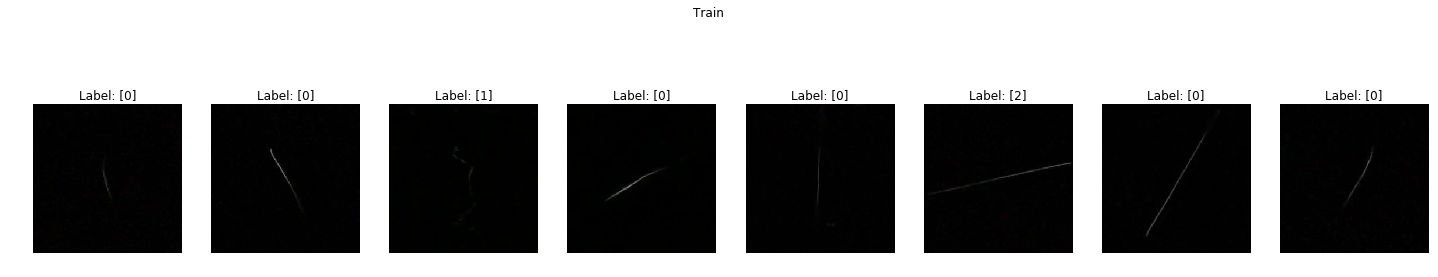

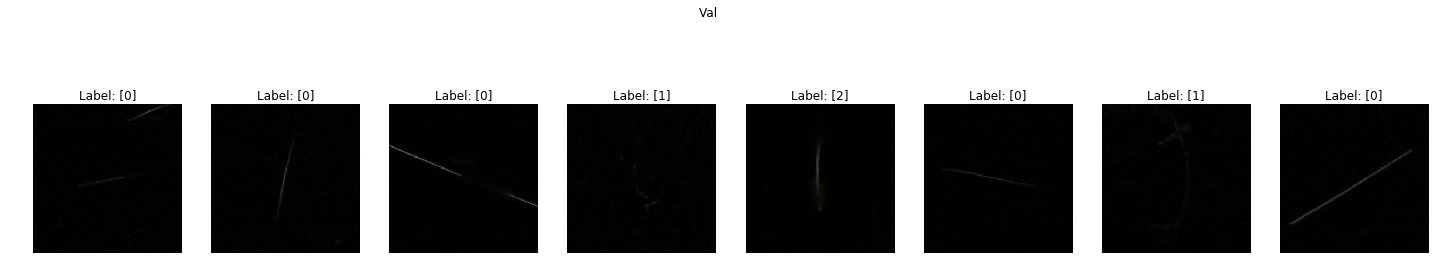

In [7]:
def plot_images(images, labels, title, num_ims=8):
    """Plot mosaic of images with matplotlib."""
    fig, axs = plt.subplots(1, num_ims, figsize=(25,5))
    plt.suptitle(title)
    for idx, (ax, im, lab) in enumerate(zip(axs, images, labels)):
        ax.imshow(im.squeeze())
        ax.axis('off')
        ax.set_title('Label: %s' % np.where(lab)[0])
    # plt.show()  # Only if not executing in ipython notebook
    print('{0} range, min: {1}, max: {2}'.format(title, images.min(), images.max()))

images, labels = next(train_datagen)
plot_images(images=images, labels=labels, title='Train')
images, labels = next(val_datagen)
plot_images(images=images, labels=labels, title='Val')

--------------------------------------------------------------------------------------

Build a model

In [8]:
def resnet_layer(
        inputs,
        num_filters=16,
        kernel_size=3,
        strides=1,
        activation='relu',
        batch_normalization=True,
        conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(input_shape, depth, num_classes=NUM_CLASSES):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(
        num_classes,
        activation='softmax',
        kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def build_finetune_model(input_shape, dropout, fc_layers, num_classes, freeze=True):
    """Load pretrained model, add readout layer, fix the convolutional layers."""
    base_model = ResNet50(
        weights='imagenet', 
        include_top=False, 
        pooling='avg',
        input_shape=input_shape)
    if freeze:
        for layer in base_model.layers:
            layer.trainable = False

    x = base_model.output
    #x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(units=fc, input_shape=input_shape, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
        #x = Dense(units=fc, input_shape=input_shape, activation='relu')(x)
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
  
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

keras.backend.clear_session()

PRETRAINED = True

if PRETRAINED:
    FC_LAYERS  = [64,32,16]  # Add more layers but adding elements to this list
    dropout    = 0.25

    model = build_finetune_model(
        input_shape=INPUT_SHAPE, 
        dropout=dropout, 
        fc_layers=FC_LAYERS, 
        num_classes=NUM_CLASSES)
    print(model.summary())
    
else:
    model = resnet_v2(input_shape=INPUT_SHAPE, depth=56)
    print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormal

Scoring and history functions for training, and model preparation

In [9]:
def show_history(history):
    """Plot training and validation performance."""
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

checkpointer = ModelCheckpoint(
    os.path.join(checkpoint_path, '%s_resnet_model.h5' % VERSION),
    verbose=2,
    save_best_only=True)
earlyStopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    mode='min',
    patience=30,
    verbose=0,
    restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    cooldown=1,
    verbose=1)
model.compile(
    loss='categorical_crossentropy',  
    optimizer=Adam(1e-3),
    metrics=['accuracy'])


Train model

In [10]:
num_train_images = len(train_ids)
num_test_images = len(test_ids)

history = model.fit_generator(
    train_datagen,
    #validation_data=next(val_datagen),
    validation_data=val_datagen,
    class_weight=classWeight,
    epochs=EPOCHS, 
    steps_per_epoch=num_train_images // TRAIN_BATCH_SIZE,
    #steps_per_epoch=num_train_images,
    validation_steps=num_test_images // VAL_BATCH_SIZE,
    verbose=1,
    callbacks=[checkpointer, earlyStopping, reduce_lr])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
145/145 [==============================] - 252s 2s/step - loss: 1.0947 - acc: 0.4690 - val_loss: 1.0852 - val_acc: 0.6345

Epoch 00001: val_loss improved from inf to 1.08524, saving model to ./v0_resnet_model.h5
Epoch 2/10
145/145 [==============================] - 249s 2s/step - loss: 0.9060 - acc: 0.5629 - val_loss: 1.0736 - val_acc: 0.6302

Epoch 00002: val_loss improved from 1.08524 to 1.07363, saving model to ./v0_resnet_model.h5
Epoch 3/10
145/145 [==============================] - 247s 2s/step - loss: 0.8177 - acc: 0.6009 - val_loss: 1.3042 - val_acc: 0.6362

Epoch 00003: val_loss did not improve from 1.07363
Epoch 4/10
145/145 [==============================] - 249s 2s/step - loss: 0.8108 - acc: 0.5966 - val_loss: 1.2974 - val_acc: 0.1276

Epoch 00004: val_loss did not improve from 1.07363
Epoch 5/10
145/145 [==============================] - 254s 2s/step - loss: 0.7446 - acc: 0.6457 - val_loss: 1.6426 - val_acc: 0.1310

Show history

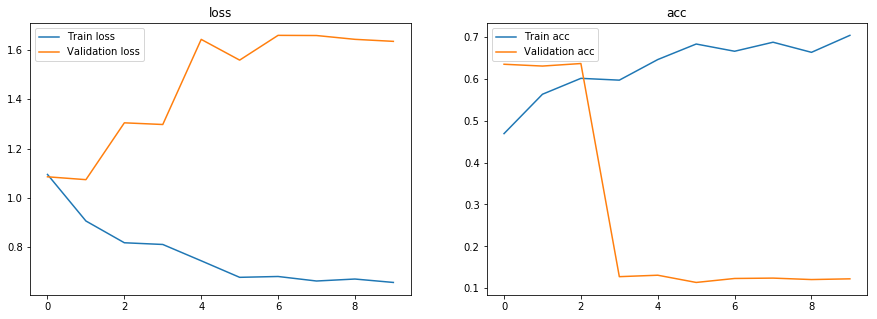

In [11]:
show_history(history)